In [1]:
import config
import os
import random
import utils

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [113]:
saltlake_week = pd.read_csv('../saltlake_week.csv')
saltlake_week

,dates,Cases,VMT (Veh-Miles),News Sentiment,Unemployment Rate,PRCP,SNOW,SNWD,Percent_Fully_Vaccinated_5&Older,Stay at Home,Mask,School Opening,Health Emergency,TAVG,TMAX,TMIN,Holiday,Day
0,201801,0.0,64342427.0,1.605530,0.031165,0.23,0.3,0.0,0.000000,0.0,0.0,1.0,0.0,31.285714,42.857143,24.571429,1.0,1/1/2018
1,201802,0.0,68283841.4,1.812110,0.031165,0.08,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,41.142857,50.428571,33.714286,0.0,1/8/2018
2,201803,0.0,65983134.6,1.437803,0.031165,0.47,8.9,11.8,0.000000,0.0,0.0,1.0,0.0,39.714286,48.714286,29.714286,1.0,1/15/2018
3,201804,0.0,68658037.2,1.218415,0.031165,0.04,0.4,12.2,0.000000,0.0,0.0,1.0,0.0,36.714286,45.714286,30.285714,0.0,1/22/2018
4,201805,0.0,69435067.4,1.386520,0.031165,0.00,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,46.428571,56.285714,38.857143,0.0,1/29/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,202203,23819.0,72930069.2,-0.170064,NaN,0.06,0.6,1.0,0.713810,0.0,1.0,1.0,0.0,30.142857,37.857143,23.857143,1.0,1/17/2022
212,202204,11750.0,76286409.8,-0.520794,NaN,0.02,0.3,0.0,0.713936,0.0,0.0,1.0,0.0,29.428571,38.857143,21.428571,0.0,1/24/2022
213,202205,6220.0,76496169.1,-0.579581,NaN,0.07,0.7,1.0,0.714011,0.0,0.0,1.0,0.0,26.714286,35.857143,18.285714,0.0,1/31/2022
214,202206,NaN,80311937.6,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,36.857143,50.285714,26.857143,NaN,2/7/2022


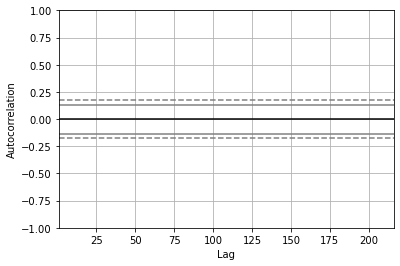

In [114]:
from pandas.plotting import autocorrelation_plot

series = saltlake_week['VMT (Veh-Miles)']
autocorrelation_plot(series)
plt.show()

In [117]:
y = saltlake_week[['Day', 'VMT (Veh-Miles)']].iloc[53:209, :]
y.columns = ['Week', 'VMT']
y['Week'] = pd.to_datetime(y['Week'])
y.head()

,Week,VMT
53,2019-01-07,66181817.1
54,2019-01-14,65217107.0
55,2019-01-21,63764156.8
56,2019-01-28,68255092.9
57,2019-02-04,60363403.4


In [118]:
y.tail()

,Week,VMT
204,2021-11-29,79550158.9
205,2021-12-06,75668913.3
206,2021-12-13,77809476.1
207,2021-12-20,71502911.8
208,2021-12-27,62352608.0


In [119]:
y.shape

(156, 2)

In [120]:
y.dtypes

Week    datetime64[ns]
VMT            float64
dtype: object

In [121]:
y.set_index('Week', inplace=True)
y.head()

,VMT
Week,
2019-01-07,66181817.1
2019-01-14,65217107.0
2019-01-21,63764156.8
2019-01-28,68255092.9
2019-02-04,60363403.4


<AxesSubplot:xlabel='Week'>

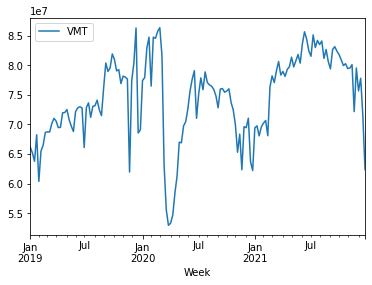

In [122]:
y.plot()

In [123]:
X = saltlake_week[['Day', 'Cases', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                         'Percent_Fully_Vaccinated_5&Older', 'TAVG',
                         'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']].iloc[53:209, :]
X.columns = ['Week', 'Cases', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                         'Percent_Fully_Vaccinated_5&Older', 'TAVG',
                         'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']
X.head()

,Week,Cases,News Sentiment,Unemployment Rate,PRCP,SNWD,Percent_Fully_Vaccinated_5&Older,TAVG,Stay at Home,Mask,School Opening,Health Emergency,Holiday
53,1/7/2019,0.0,-0.589684,0.029341,0.07,6.4,0.0,32.285714,0.0,0.0,1.0,0.0,0.0
54,1/14/2019,0.0,-0.716851,0.029341,0.85,1.2,0.0,33.428571,0.0,0.0,1.0,0.0,0.0
55,1/21/2019,0.0,-0.795640,0.029341,0.62,13.3,0.0,31.571429,0.0,0.0,1.0,0.0,1.0
56,1/28/2019,0.0,-0.791056,0.027660,0.07,0.0,0.0,36.142857,0.0,0.0,1.0,0.0,0.0
57,2/4/2019,0.0,-0.327101,0.027660,0.60,19.1,0.0,31.285714,0.0,0.0,1.0,0.0,0.0


In [124]:
X['Week'] = pd.to_datetime(X['Week'])
X.dtypes

Week                                datetime64[ns]
Cases                                      float64
News Sentiment                             float64
Unemployment Rate                          float64
PRCP                                       float64
SNWD                                       float64
Percent_Fully_Vaccinated_5&Older           float64
TAVG                                       float64
Stay at Home                               float64
Mask                                       float64
School Opening                             float64
Health Emergency                           float64
Holiday                                    float64
dtype: object

In [125]:
X.set_index('Week', inplace=True)
X.head()

,Cases,News Sentiment,Unemployment Rate,PRCP,SNWD,Percent_Fully_Vaccinated_5&Older,TAVG,Stay at Home,Mask,School Opening,Health Emergency,Holiday
Week,,,,,,,,,,,,
2019-01-07,0.0,-0.589684,0.029341,0.07,6.4,0.0,32.285714,0.0,0.0,1.0,0.0,0.0
2019-01-14,0.0,-0.716851,0.029341,0.85,1.2,0.0,33.428571,0.0,0.0,1.0,0.0,0.0
2019-01-21,0.0,-0.795640,0.029341,0.62,13.3,0.0,31.571429,0.0,0.0,1.0,0.0,1.0
2019-01-28,0.0,-0.791056,0.027660,0.07,0.0,0.0,36.142857,0.0,0.0,1.0,0.0,0.0
2019-02-04,0.0,-0.327101,0.027660,0.60,19.1,0.0,31.285714,0.0,0.0,1.0,0.0,0.0


In [126]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(y)

(0.06504345249740989, True)

In [127]:
from pmdarima.arima import KPSSTest
kpss_test = KPSSTest(alpha = 0.05)
kpss_test.should_diff(y)

(0.017734973124697174, True)

In [128]:
trainX = X.iloc[:148, :]
trainY = y.iloc[:148, :]
testX = X.iloc[148:, :]
testY = y.iloc[148:, :]
print(trainX.shape)
print(testY.shape)

(148, 12)
(8, 1)


In [129]:
trainX.tail()

,Cases,News Sentiment,Unemployment Rate,PRCP,SNWD,Percent_Fully_Vaccinated_5&Older,TAVG,Stay at Home,Mask,School Opening,Health Emergency,Holiday
Week,,,,,,,,,,,,
2021-10-04,3023.0,-1.283800,0.018205,0.77,0.0,0.656495,59.857143,0.0,0.0,1.0,0.0,0.0
2021-10-11,2747.0,-1.162625,0.018205,0.45,0.0,0.659226,45.000000,0.0,0.0,1.0,0.0,1.0
2021-10-18,3232.0,-1.070546,0.018205,1.03,0.0,0.661640,50.142857,0.0,0.0,1.0,0.0,0.0
2021-10-25,3514.0,-0.332263,0.018205,1.24,0.0,0.664056,51.428571,0.0,0.0,1.0,0.0,0.0
2021-11-01,3676.0,-0.036116,0.024257,0.06,0.0,0.669969,51.571429,0.0,0.0,1.0,0.0,0.0


In [130]:
testX.head()

,Cases,News Sentiment,Unemployment Rate,PRCP,SNWD,Percent_Fully_Vaccinated_5&Older,TAVG,Stay at Home,Mask,School Opening,Health Emergency,Holiday
Week,,,,,,,,,,,,
2021-11-08,3823.0,0.313240,0.024257,0.25,0.0,0.683879,47.000000,0.0,0.0,1.0,0.0,1.0
2021-11-15,3695.0,0.225556,0.024257,0.03,0.0,0.692777,42.571429,0.0,0.0,1.0,0.0,0.0
2021-11-22,2705.0,0.416588,0.024257,0.00,0.0,0.696802,36.142857,0.0,0.0,1.0,0.0,1.0
2021-11-29,3722.0,0.238616,0.024257,0.00,0.0,0.700688,40.285714,0.0,0.0,1.0,0.0,0.0
2021-12-06,2923.0,0.119803,0.017357,0.57,3.6,0.704118,35.571429,0.0,0.0,1.0,0.0,0.0


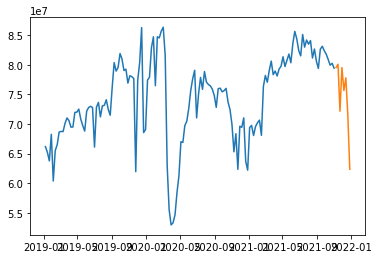

In [131]:
plt.plot(trainY)
plt.plot(testY)

In [132]:
from pmdarima.arima import auto_arima

In [133]:
arima_model =  auto_arima(trainY, trainX, start_p=1, d=1, start_q=1, 
                          max_p=10, max_d=5, max_q=5, 
                          start_P=0, D=None, start_Q=0, 
                          max_P=5, max_D=5, max_Q=5, 
                          m=52, seasonal=True, error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=seed_value,n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=4834.096, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=4831.087, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=4826.059, Time=3.69 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=4826.825, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=5416.703, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=4832.654, Time=0.24 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=4826.457, Time=7.42 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=4826.623, Time=3.85 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=4826.873, Time=1.35 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=4828.428, Time=23.13 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=4824.538, Time=1.38 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=4824.908, Time=6.51 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=4825.047, Time=5.46 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=4825.353, Time=2.10 sec
 ARIMA(0,1,0)(2,0,

In [103]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  201
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 52)   Log Likelihood               -3256.016
Date:                            Thu, 17 Feb 2022   AIC                           6540.032
Time:                                    14:37:32   BIC                           6586.209
Sample:                                         0   HQIC                          6558.719
                                            - 201                                         
Covariance Type:                              opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Cases                              -94.8573    637.384     -0.149      0.882   -1344.107    1154.392
News Sentiment                    9.912e+05   2.54e+05      3.909      0.000    4.94e+05    1.49e+06
Unemployment Rate                -7.467e+07    153.421  -4.87e+05      0.000   -7.47e+07   -7.47e+07
PRCP                             -1.988e+06   5.54e+05     -3.590      0.000   -3.07e+06   -9.03e+05
SNWD                             -1.975e+05   3.78e+04     -5.219      0.000   -2.72e+05   -1.23e+05
Percent_Fully_Vaccinated_5&Older   8.84e+06   2189.347   4037.892      0.000    8.84e+06    8.84e+06
TAVG                              2.301e+04   5.04e+04      0.456      0.648   -7.58e+04    1.22e+05
Stay at Home                     -4.045e+06    416.899  -9702.071      0.000   -4.05e+06   -4.04e+06
Mask                             -2.622e+06   2.82e+04    -93.038      0.000   -2.68e+06   -2.57e+06
School Opening                    1.529e+06   2.94e+05      5.197      0.000    9.53e+05    2.11e+06
Health Emergency                  1.945e+06   1.09e+04    179.217      0.000    1.92e+06    1.97e+06
Holiday                          -2.733e+06   3.65e+05     -7.490      0.000   -3.45e+06   -2.02e+06
ar.S.L52                             0.1084      0.030      3.641      0.000       0.050       0.167
sigma2                            8.303e+12      0.265   3.13e+13      0.000     8.3e+12     8.3e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):               570.54
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -1.32
Prob(H) (two-sided):                  0.05   Kurtosis:                        10.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.84e+27. Standard errors may be unstable.
"""

In [104]:
arima_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 0, 52),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [105]:
arima_model.arima_res_.data.endog.shape

(201,)

In [106]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 8, X=testX),index=testX.index)
prediction.columns = ['Predicted_VMT']
prediction

C:\Users\aawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,Predicted_VMT
Week,
2021-11-08,7.664084e+07
2021-11-15,7.955796e+07
2021-11-22,7.670165e+07
2021-11-29,7.980217e+07
2021-12-06,7.833669e+07
2021-12-13,7.331243e+07
2021-12-20,7.350894e+07
2021-12-27,7.102882e+07


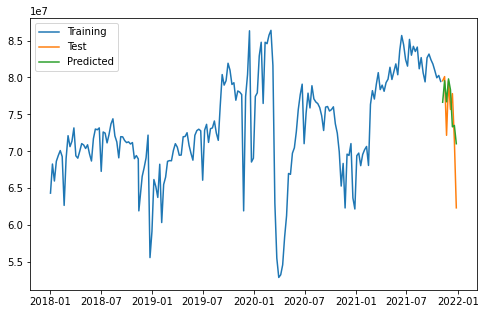

In [107]:
plt.figure(figsize=(8,5))
plt.plot(trainY,label="Training")
plt.plot(testY,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [108]:
from sklearn.metrics import r2_score
testY = pd.DataFrame(testY)
testY['Predicted_VMT'] = prediction
testY

,VMT,Predicted_VMT
Week,,
2021-11-08,79542545.3,7.664084e+07
2021-11-15,80116497.7,7.955796e+07
2021-11-22,72167973.1,7.670165e+07
2021-11-29,79550158.9,7.980217e+07
2021-12-06,75668913.3,7.833669e+07
2021-12-13,77809476.1,7.331243e+07
2021-12-20,71502911.8,7.350894e+07
2021-12-27,62352608.0,7.102882e+07


In [109]:
r2_score(testY['VMT'], testY['Predicted_VMT'])

0.4684880092607864

In [110]:
mean_absolute_percentage_error(testY['VMT'], testY['Predicted_VMT'])

0.0462118680873774

In [111]:
mean_squared_error(testY['VMT'], testY['Predicted_VMT'])

16998861476419.91

In [112]:
mean_squared_error(testY['VMT'], testY['Predicted_VMT'], squared=False)

4122967.5570418825